In [1]:
import numpy as np
from numpy.linalg import matrix_rank
import random
import scipy
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
import time
import pandas as pd
import ast

In [2]:
class Node:
    def __init__(self):
        self.rank = None
        self.size = None
        self.singular_values = None
        self.U = None
        self.V = None
        self.sons = None

In [25]:
def bound(a, b, value):
    if a > b:
        a, b = b, a
    return max(a, min(value, b))

def compare(A, B):
    return np.allclose(np.array(A, dtype=float), np.array(B, dtype=float), rtol=1e-05,
                           atol=1e-08, equal_nan=False)
def create_M(n):
    return np.array([[(random.uniform(0.00000001, 1)) for _ in range(n)] for _ in range(n)])
def create_sparse(n, density):
    rng = np.random.default_rng()
    A = sparse.random(n, n, density=density, random_state=rng)
    return np.array(A.A)
def matrix_partition(A):
    n = A.shape[0] // 2
    m = A.shape[1] // 2
    A11 = A[:n, :m]
    A12 = A[:n, m:]
    A21 = A[n:, :m]
    A22 = A[n:, m:]
    return A11, A12, A21, A22

def matrix_repartition(A11, A12, A21, A22):
    C = np.block([[A11, A12],
                  [A21, A22]])
    return C
def find_s_index_for_delta(s, delta):
    if s.size == 0:
        return 0
    if s[0] <= delta:
        return 0
    for i in range(len(s)):
        if s[i] <= delta:
            return i
    return len(s)-1
def truncated_SVD(A, delta, b):
    b = b-1
    U, s, V = np.linalg.svd(A)
    i = find_s_index_for_delta(s, delta)
    idx = min(i, b, len(s))
    return U[:, :idx + 1], s[:idx+1], V[:idx + 1, :]
    # return randomized_svd(A, n_components=b)
def show_array(repr, name, zeros=False):
    if zeros:
        plt.spy((repr != 0).astype(int))
    else:
        plt.spy(repr)
    plt.grid(False)
    plt.title(name)
    plt.savefig("plots/"+name+".png")

def show_arrays(repr1, repr2, zeros=False):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if zeros:
        plt.spy((repr1 != 0).astype(int))
    else:
        plt.spy(repr1)
    plt.colorbar()
    plt.grid(False)
    plt.title('Array 1')

    # Plot the second array
    plt.subplot(1, 2, 2)
    if zeros:
        plt.spy((repr2 != 0).astype(int))
    else:
        plt.spy(repr2)
    plt.colorbar()
    plt.title('Array 2')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def U_V_to_array(U, V):
    n = U.shape[0]
    m = U.shape[1]
    repr = np.zeros((n, n))
    repr[:n, :m] = U
    repr[:m, :n] = V
    return repr
def MSE(A, B):
    return ((A - B)**2).mean()

In [4]:
def compress_matrix(A, delta, b):
    if not np.any(A):
        v = Node()
        v.rank = 0
        v.size = A.shape
        return v
    U, s, V = truncated_SVD(A, delta, b)
    rank = matrix_rank(s)
    v = Node()
    v.rank = rank
    v.U = U * s
    v.V = V
    v.size = A.shape
    return v
def create_tree(A, r, e):
    r = bound(min(A.shape[0], A.shape[1]), 0, r+1)
    U, s, V = truncated_SVD(A, e, r + 1)
    if s[-1] < e or U.shape[0] <= r:
        v = compress_matrix(A, e, r)
    else:
        v = Node()
        A11, A12, A21, A22 = matrix_partition(A)
        v.sons = [create_tree(A11, r, e),
                  create_tree(A12, r, e),
                  create_tree(A21, r, e),
                  create_tree(A22, r, e)]
    return v
def recover_matrix(v):
    if v.sons:
        m = matrix_repartition(recover_matrix(v.sons[0]), recover_matrix(v.sons[1]),
                               recover_matrix(v.sons[2]), recover_matrix(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = v.U @ v.V
    return m
def tree_to_repr(v):
    if v.sons:
        m = matrix_repartition(tree_to_repr(v.sons[0]), tree_to_repr(v.sons[1]),
                               tree_to_repr(v.sons[2]), tree_to_repr(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = U_V_to_array(v.U, v.V)
    return m

In [5]:
def stat_functions(nonzero_percentages):
    df_ss = pd.DataFrame()
    df_times = pd.DataFrame()
    df_repr = pd.DataFrame()
    df_msa = pd.DataFrame()
    for val in nonzero_percentages:
        A = create_sparse(2**10, val)
        U, s, V = np.linalg.svd(A)
        sigmas = {"sigma_two":s[1], "sigma_half":s[len(s)//2], "sigma_last":s[-1]}
        bs = {"b_1":1, "b_4":4}
        # add s to dataframe
        df_ss = df_ss._append({"nonzero_percentage":val, "s":s}, ignore_index=True)
        for sigma_name, sigma in sigmas.items():
            for b_name, b in bs.items():
                print(val, b_name, sigma_name, end=" ")
                start_time = time.time()
                tree = create_tree(A, b, sigma)
                # add time to dataframe
                df_times = df_times._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "time":time.time() - start_time}, ignore_index=True)
                # add repr to dataframe
                df_repr = df_repr._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "repr":tree_to_repr(tree)}, ignore_index=True)
                B = recover_matrix(tree)
                df_msa = df_msa._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "msa":MSE(A, B)}, ignore_index=True)

    return df_ss, df_times, df_repr, df_msa

In [6]:
df_ss, df_times, df_repr, df_msa = stat_functions([0.01, 0.02, 0.05, 0.1, 0.2])

0.01 b_1 sigma_two 0.01 b_4 sigma_two 0.01 b_1 sigma_half 0.01 b_4 sigma_half 0.01 b_1 sigma_last 0.01 b_4 sigma_last 0.02 b_1 sigma_two 0.02 b_4 sigma_two 0.02 b_1 sigma_half 0.02 b_4 sigma_half 0.02 b_1 sigma_last 0.02 b_4 sigma_last 0.05 b_1 sigma_two 0.05 b_4 sigma_two 0.05 b_1 sigma_half 0.05 b_4 sigma_half 0.05 b_1 sigma_last 0.05 b_4 sigma_last 0.1 b_1 sigma_two 0.1 b_4 sigma_two 0.1 b_1 sigma_half 0.1 b_4 sigma_half 0.1 b_1 sigma_last 0.1 b_4 sigma_last 0.2 b_1 sigma_two 0.2 b_4 sigma_two 0.2 b_1 sigma_half 0.2 b_4 sigma_half 0.2 b_1 sigma_last 0.2 b_4 sigma_last 

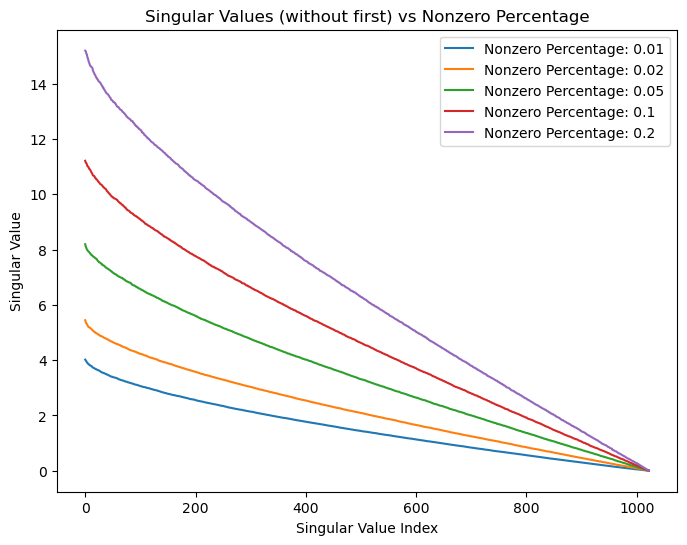

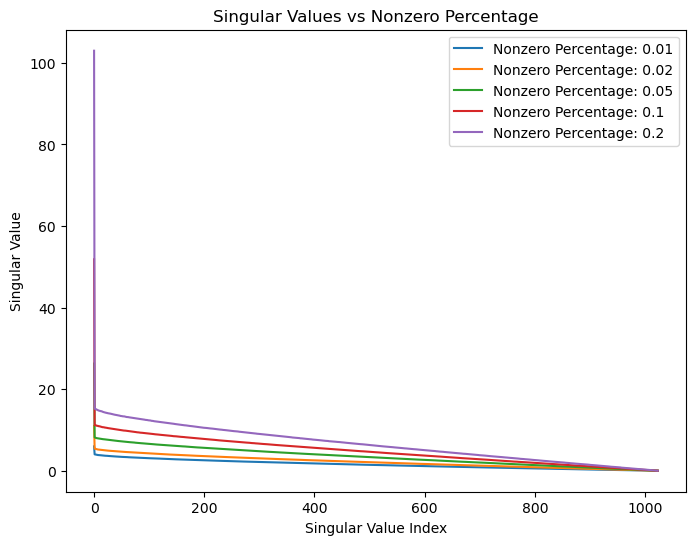

In [7]:
df_times.to_csv("df_times.csv", index=True)
df_msa.to_csv("df_msa.csv", index=True)
df_times = pd.read_csv("df_times.csv", index_col=0)
df_msa = pd.read_csv("df_msa.csv", index_col=0)
def plot_s_values(df, first=False):
    plt.figure(figsize=(8, 6))
    for index, row in df.iterrows():
        if first:
            plt.plot(row['s'], label=f"Nonzero Percentage: {row['nonzero_percentage']}")
        else:
            plt.plot(row['s'][1:], label=f"Nonzero Percentage: {row['nonzero_percentage']}")

    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value')
    plt.legend()
    if first:
        plt.title('Singular Values vs Nonzero Percentage')
    else:
        plt.title('Singular Values (without first) vs Nonzero Percentage')
    plt.show()
plot_s_values(df_ss)
plot_s_values(df_ss, True)
# df_ss

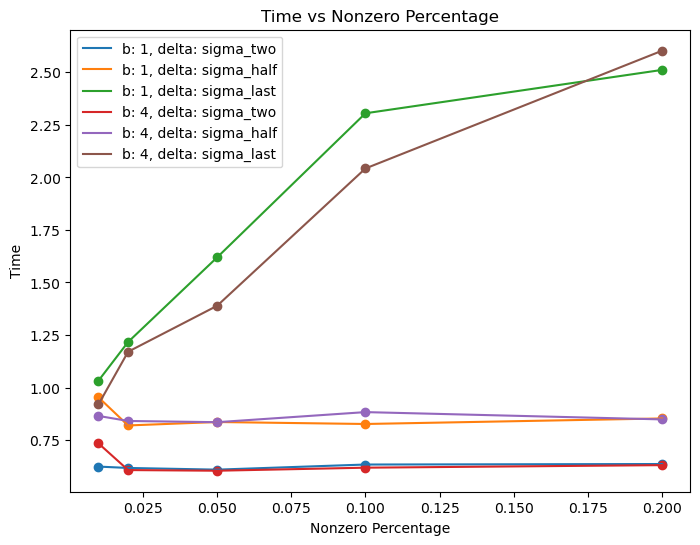

In [8]:
def plot_times(df_times):
    plt.figure(figsize=(8, 6))
    for b_name in df_times['b'].unique():
        for sigma_name in df_times['sigma'].unique():

            # plot with points and lines
            plt.plot(df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['nonzero_percentage'],
                     df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['time'],
                     label=f"b: {b_name[-1]}, delta: {sigma_name}")
            plt.scatter(df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['nonzero_percentage'], df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['time'])


    plt.xlabel('Nonzero Percentage')
    plt.ylabel('Time')
    plt.legend()
    plt.title('Time vs Nonzero Percentage')
    plt.show()

plot_times(df_times)

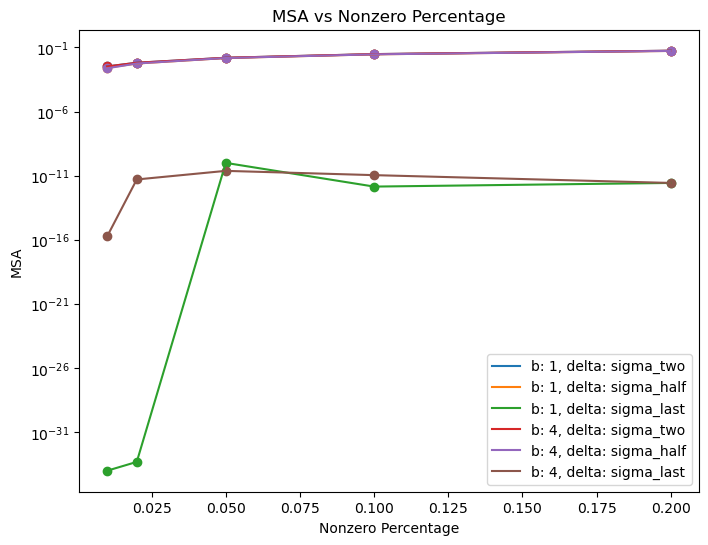

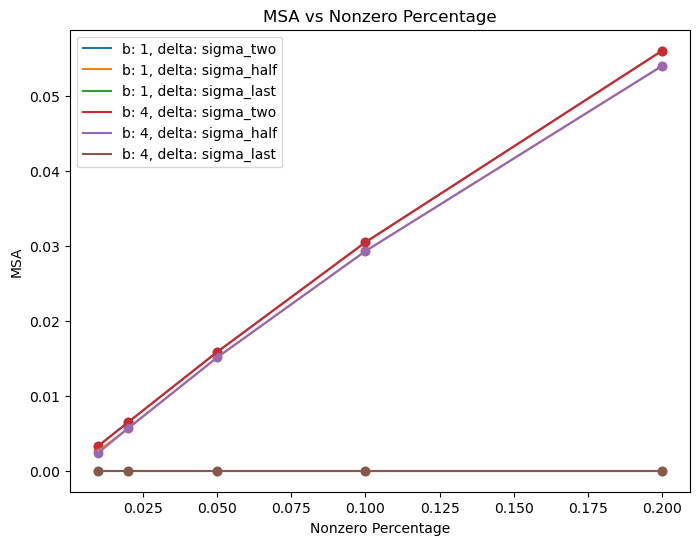

In [9]:
def plot_msa(df_msa, log=True):
    plt.figure(figsize=(8, 6))
    for b_name in df_msa['b'].unique():
        for sigma_name in df_msa['sigma'].unique():

            # plot with points and lines
            plt.plot(df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['nonzero_percentage'],
                     df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['msa'],
                     label=f"b: {b_name[-1]}, delta: {sigma_name}")
            plt.scatter(df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['nonzero_percentage'], df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['msa'])
    # add log scale

    if log:
        plt.yscale('log')

    plt.xlabel('Nonzero Percentage')
    plt.ylabel('MSA')
    plt.legend()
    plt.title('MSA vs Nonzero Percentage')
    plt.show()

plot_msa(df_msa)
plot_msa(df_msa, False)

b_1 sigma_two 0.01
b_1 sigma_two 0.02
b_1 sigma_two 0.05
b_1 sigma_two 0.1
b_1 sigma_two 0.2
b_1 sigma_half 0.01
b_1 sigma_half 0.02
b_1 sigma_half 0.05
b_1 sigma_half 0.1
b_1 sigma_half 0.2
b_1 sigma_last 0.01
b_1 sigma_last 0.02
b_1 sigma_last 0.05
b_1 sigma_last 0.1
b_1 sigma_last 0.2
b_4 sigma_two 0.01
b_4 sigma_two 0.02
b_4 sigma_two 0.05
b_4 sigma_two 0.1
b_4 sigma_two 0.2
b_4 sigma_half 0.01
b_4 sigma_half 0.02
b_4 sigma_half 0.05
b_4 sigma_half 0.1
b_4 sigma_half 0.2
b_4 sigma_last 0.01
b_4 sigma_last 0.02
b_4 sigma_last 0.05
b_4 sigma_last 0.1
b_4 sigma_last 0.2


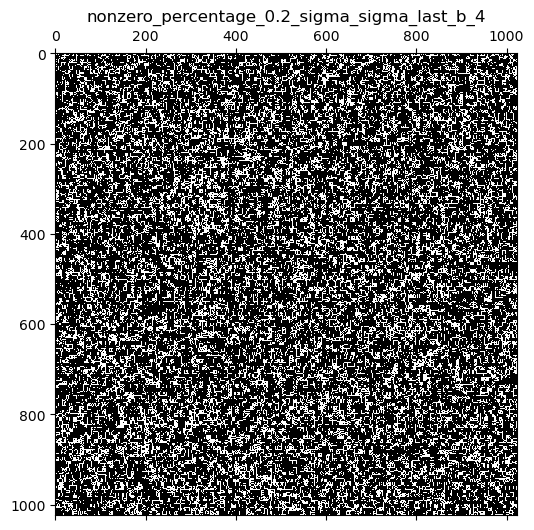

In [27]:
def plot_repr(df_repr):
    plt.figure(figsize=(8, 6))
    for b_name in df_repr['b'].unique():
        for sigma_name in df_repr['sigma'].unique():
            for nonzero_percentage in df_repr['nonzero_percentage'].unique():
                print(b_name, sigma_name, nonzero_percentage)
                show_array(df_repr[(df_repr['b'] == b_name) & (df_repr['sigma'] == sigma_name) & (df_repr['nonzero_percentage'] == nonzero_percentage)]['repr'].iloc[0], f"nonzero_percentage_{nonzero_percentage}_sigma_{sigma_name}_b_{b_name[-1]}", True)


plot_repr(df_repr)